# Releasing data with ONE
ONE can operate in [two modes](./one_modes.html). For very large collections, such as the main IBL
data, it operates in 'remote mode', downloading data from a remote store only as required.
However it can also be used in 'local mode', in which all data files are stored on the user's
local machine.  This is simpler, and allows access with no internet connection.
To access data in local mode, a user uses exactly the same commands as in remote mode.

ONE stores an index of the local filesystem in a couple of parquet files in the root directory,
called 'sessions.pqt' and 'datasets.pqt'.

The easiest way for data producers to release ONE-standard data is thus to create a directory
containing your data files, collect them all into a .zip file, and put it on a website along
with the index files.

Users can then download and unzip your data files, and access them using ONE local mode.

For information about creating and validating ONE-standard data (a.k.a. ALFs) see the [guide on
datasets](./datasets_and_types.html).

This guide is for releasing data without an Alyx database.  If using an Alyx database instance and
wish to share dataset UUIDs with others, see [recording data access](./recording_data_access.html).

In this tutorial we will show how to create the index files.

First [install ONE](../one_installation.html):

```
pip install ONE-api
```

## Downloading example data
Next we are going to download an example collection of behavioural data files.  The following
commands download a zip file from figshare into a cache directory, and unzip it.  It is of course
also possible to download and unzip the file manually, in any directory of the users choice.
This should take around a minute.

The dataset is around 74,000 behaviour files (~218MB) from the beta data release for the [IBL
behaviour paper](https://elifesciences.org/articles/63711).  The code in this cell is not important.

<div class="alert alert-info">
Note.

The zip file is for demonstrating how to prepare data for ONE and therefore doesn't yet contain
index files.  Normally when releasing data you would include the index files.  It is also not
a complete set of behaviour sessions used in the accompanying paper.
</div>

In [1]:
from pathlib import Path

from one.api import One
from one.params import CACHE_DIR_DEFAULT
import requests
from io import BytesIO
import zipfile

# Data locations:
# The data_url is the location of the remote example dataset.  This will be downloaded so we
# have something to build a cache from on our local computer.
data_url = 'https://ndownloader.figshare.com/files/21623715'

# The cache_dir is the location of the example dataset.  By default this will be
# ~/Downloads/ONE/my_example but could be set to anything.
cache_dir = Path(CACHE_DIR_DEFAULT, 'my_example')

# Download data if not already downloaded
if not (cache_dir.exists() and any(cache_dir.iterdir())):
    cache_dir.parent.mkdir(exist_ok=True, parents=True)  # Create destination dir
    print(f'Downloading data from {data_url.split(".", maxsplit=1)[-1]}...')
    request = requests.get(data_url)  # Download data into memory (~300MB)
    with zipfile.ZipFile(BytesIO(request.content)) as zipped:
        print(f'Extracting into {cache_dir}...')
        zipped.extractall(path=cache_dir.parent)  # Decompress into destination dir
    Path(cache_dir.parent, 'ibl-behavioral-data-Dec2019').rename(cache_dir)  # Rename
    cache_dir.joinpath('one_example.py').unlink()  # Delete outdated example
    del request  # Free resources


Extracting into C:\Users\User\Downloads\ONE\my_example...


## Validating your data
Before building the cache tables, you need to organize your data files into directories with a
specific naming convention:

`lab/Subjects/subject/date/number`

<div class="alert alert-info">
Note.

If releasing data from a single lab, the `lab/Subjects` directories are not necessary.  The
`subject/date/number` structure, however, is always required.
</div>

Now let's have a look inside the data directory. For the first recording made from Zador lab
subject `CSH_ZAD_003` on 11 August 2019, the files are in the path
`zadorlab/Subjects/CSH_ZAD_003/2019-08-11/001/alf`.


In [8]:
import os
print(os.listdir(cache_dir))
session_path = cache_dir.joinpath('zadorlab/Subjects/CSH_ZAD_003/2019-08-11/001/alf')
print(os.listdir(session_path))

['angelakilab', 'churchlandlab', 'cortexlab', 'danlab', 'datasets.pqt', 'hoferlab', 'mainenlab', 'mrsicflogellab', 'README.txt', 'sessions.pqt', 'wittenlab', 'zadorlab']
['_ibl_trials.choice.npy', '_ibl_trials.contrastLeft.npy', '_ibl_trials.contrastRight.npy', '_ibl_trials.feedbackType.npy', '_ibl_trials.feedback_times.npy', '_ibl_trials.goCueTrigger_times.npy', '_ibl_trials.goCue_times.npy', '_ibl_trials.included.npy', '_ibl_trials.intervals.npy', '_ibl_trials.probabilityLeft.npy', '_ibl_trials.repNum.npy', '_ibl_trials.response_times.npy', '_ibl_trials.rewardVolume.npy', '_ibl_trials.stimOnTrigger_times.npy', '_ibl_trials.stimOn_times.npy']


Within this directory, the datasets are named with standard [ONE file naming conventions](../alf_intro.html).
Files that are not withing the right directory structure or that don't have a valid filename
will not be added to the cache tables.  Before building the cache you should check that your
datasets are ALF compliant:

In [9]:
from one.alf.spec import is_valid
assert all(is_valid(x) for x in os.listdir(session_path))

## Generating the cache
Now let's see how you would release data in ONE standard if you are a data producer.  Before
zipping and uploading, you need to create the index files, which is done with one line of code.
This should take about 3 minutes for the current behavioral data.

<div class="alert alert-info">
Note.

The option `hash_files` creates a hash of each file which allows ONE to detect when files have
changed - this is good for dynanmic data stored on an Alyx but is not necessary for release of
zipped data on a website.
</div>

In [3]:
print('Building ONE cache from filesystem...')
One.setup(cache_dir, hash_files=False)

Building ONE cache from filesystem...


One (offline, C:\Users\User\Downloads\ONE\my_example)

## Checking the cache
Now the files are indexed you can use ONE search and load commands as you would with
remote data. Let's search for all sessions of subject NYU-01, that have behavioral trial data,
then make a plot of reaction time vs. trial number which we obtain by subtracting the time of the
go cue onset from the feedback (i.e. reward or failure) time.

For more information on listing, searching and loading data see [the API guides](../index.html#basic-usage)

There are 98 behaviour sessions for subject "NYU-01"


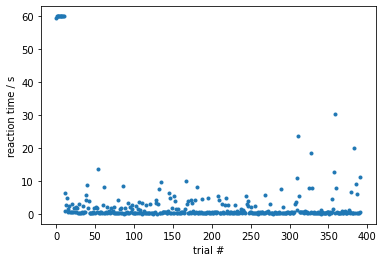

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

one = One(cache_dir=cache_dir)

# Searching for behaviour experiment by subject
subject = 'NYU-01'
eids = one.search(subject=subject, dataset=['trials.goCue_times', 'trials.feedback_times'])
print(f'There are {len(eids)} behaviour sessions for subject "{subject}"')

# Load the trials object for this session
trials = one.load_object(eids.pop(), 'trials')

# Make the plot
plt.plot(trials.feedback_times - trials.goCue_times, '.')
plt.ylabel('reaction time / s')
plt.xlabel('trial #');

Now to release the data, just zip up the directory and upload to your favourite web hosting
service!

<div class="alert alert-info">
Note.

If you are using an Alyx database instance, this is not the correct way to release data or generate
cache files as the UUIDs will not match.  Instead, generate the cache through the database
`one_cache` management command.  If you are using Alyx and wish to share accessed dataset UUIDs
with others, see [recording data access](./recording_data_access.html).
</div>